In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

In [2]:
RANDOM_SEED = 2
IMAGE_SHAPE = 784
ENCODER_H1_SHAPE = 256
ENCODER_H2_SHAPE = 128
LATENT_SHAPE = 24
DECODER_H1_SHAPE = 128
DECODER_H2_SHAPE = 256
EPOCHS = 100
BATCH_SIZE = 100
LEARNING_RATE = 0.05
ALPHA = 1.0
BETA = 1.0
LEAKY_RELU_ALPHA = 0.01


In [3]:
def ReLU(x):
    return np.maximum(0, x)

def dReLU(x):
    return np.where(x > 0, 1, 0)

def linear(x):
    return x

def dlinear(x):
    return np.ones_like(x)

def leaky_ReLU(x):
    return np.where(x > 0, x, x * LEAKY_RELU_ALPHA)

def dleaky_ReLU(x):
    return np.where(x > 0, 1, LEAKY_RELU_ALPHA)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def mse_loss(x, x_hat):
    return np.mean(np.sum((x - x_hat)**2, axis=1))

def dmse_loss(x, x_hat):
    return -2 * (x - x_hat) / x.shape[0]

def kl_error(mu, log_var):
    return np.mean(-0.5 * np.sum(1 + log_var - mu**2 - np.exp(log_var), axis=1))

def dkl_error_mu(mu, log_var): #L = -ELBO (sign flipped)
    dmu = mu
    return dmu / mu.shape[0]

def dkl_error_logvar(mu, log_var): #L = -ELBO (sign flipped)
    dlogvar = 0.5 * (np.exp(log_var) - 1)
    return dlogvar / mu.shape[0]

def one_hot(y, batch_size, output_size): #across a batch, y is a vector
    out = np.zeros((batch_size, output_size))
    out[range(batch_size), y.T] = 1 #numpy indexing trick
    return out

In [4]:
class Layer:
    def __init__(self, size, input_size, activation, dactivation):
        assert size > 0, "Size must be a positive integer"
        assert input_size > 0, "Input size must be a positive integer"
        assert callable(activation), "Activation must be a callable function"
        assert callable(dactivation), "Derivative of activation must be a callable function"

        self.__size = size
        self.__dactivation = dactivation
        self.z = None
        self.input_size = input_size
        self.weights = None
        self.biases = None
        self.values = None
        self.dweights = None
        self.dbiases = None
        self.__activation = activation

    def get_size(self):
        return self.__size
    
    def get_activation(self):
        return self.__activation
    
    def random_he_initialize(self):
        rng = np.random.standard_normal
        self.weights = rng((self.input_size, self.__size)) * np.sqrt(2 / self.input_size)
        self.biases = np.zeros((1, self.__size))
        return self.weights, self.biases

    def forward_prop(self, input):
        input = np.array(input)
        self.z = input @ self.weights + self.biases
        self.values = self.__activation(self.z)
        return self.values
    
    def backward_prop(self, input, delta): # divide by batch size in loss derivative
        delta = delta * self.__dactivation(self.z)
        self.dweights = input.T @ delta
        self.dbiases = np.sum(delta, axis=0, keepdims=True)
        delta = delta @ self.weights.T
        return delta
    
    def update_params(self, learning_rate):
        self.weights -= learning_rate * self.dweights
        self.biases -= learning_rate * self.dbiases

In [5]:
#test layer class
test_layer = Layer(5, 3, activation=ReLU, dactivation=dReLU)
test_layer.random_he_initialize()
input = np.array([[1, 2, 3], [4, 5, 6]])
output = test_layer.forward_prop(input)
print("Forward Propagation Output:")
print(output)
delta = np.array([[0.1, 0.2, 0.3, 0.4, 0.5], [0.5, 0.4, 0.3, 0.2, 0.1]])
backprop_delta = test_layer.backward_prop(input, delta)
print("Backward Propagation Delta:")
print(backprop_delta)
test_layer.update_params(learning_rate=0.01)
print("Updated Weights:")  
print(test_layer.weights)
print("Updated Biases:")
print(test_layer.biases)

Forward Propagation Output:
[[ 4.54836676  0.          1.22587354  0.80884273  0.37715117]
 [11.0220399   0.          4.46033552  0.38844835  0.89360366]]
Backward Propagation Delta:
[[-0.22221504  0.81749306 -0.02601989]
 [ 0.23013122  0.87304999  0.2883993 ]]
Updated Weights:
[[ 0.24775023  0.58972891  1.01143118 -0.85174472 -0.45124305]
 [ 1.36080591 -0.21147326 -0.06527393  0.43225232  1.00878743]
 [ 0.4683349  -0.40519479  0.06899674  0.22536093 -0.43039354]]
Updated Biases:
[[-0.006  0.    -0.006 -0.006 -0.006]]


In [6]:
class VAE: 
    def __init__(self):
        self.encoder_h1 = Layer(ENCODER_H1_SHAPE, IMAGE_SHAPE, activation=leaky_ReLU, dactivation=dleaky_ReLU)
        self.encoder_h2 = Layer(ENCODER_H2_SHAPE, ENCODER_H1_SHAPE, activation=leaky_ReLU, dactivation=dleaky_ReLU)
        self.z_mu = Layer(LATENT_SHAPE, ENCODER_H2_SHAPE, activation=linear, dactivation=dlinear)
        self.z_log_var = Layer(LATENT_SHAPE, ENCODER_H2_SHAPE, activation=linear, dactivation=dlinear)
        self.decoder_h1 = Layer(DECODER_H1_SHAPE, LATENT_SHAPE, activation=leaky_ReLU, dactivation=dleaky_ReLU)
        self.decoder_h2 = Layer(DECODER_H2_SHAPE, DECODER_H1_SHAPE, activation=leaky_ReLU, dactivation=dleaky_ReLU)
        self.output_layer = Layer(IMAGE_SHAPE, DECODER_H2_SHAPE, activation=sigmoid, dactivation=dsigmoid)

    def initialize_weights(self, seed=None):
        if seed is not None: np.random.seed()
        self.encoder_h1.random_he_initialize()
        self.encoder_h2.random_he_initialize()
        self.z_mu.random_he_initialize()
        self.z_log_var.random_he_initialize()
        self.decoder_h1.random_he_initialize()
        self.decoder_h2.random_he_initialize()
        self.output_layer.random_he_initialize()
    
    def encode(self, x):
        h1 = self.encoder_h1.forward_prop(x)
        h2 = self.encoder_h2.forward_prop(h1)
        z_mu = self.z_mu.forward_prop(h2)
        z_log_var = self.z_log_var.forward_prop(h2)
        return z_mu, z_log_var
    
    def reparameterize(self, z_mu, z_log_var):
        eps = np.random.normal(size=z_mu.shape)
        z = z_mu + np.exp(0.5 * z_log_var) * eps
        return eps, z
    
    def decode(self, z):
        h1 = self.decoder_h1.forward_prop(z)
        h2 = self.decoder_h2.forward_prop(h1)
        reconstructed_x = self.output_layer.forward_prop(h2)
        return reconstructed_x
    
    def compute_loss(self, x, z_mu, z_log_var, reconstructed_x, alpha=1.0, beta=1.0):
        mse = mse_loss(x, reconstructed_x)
        kl = kl_error(z_mu, z_log_var)
        return (mse * alpha + kl * beta), mse, kl

    def backprop(self, z_mu, z_log_var, z, reconstructed_x, x, eps, alpha=1.0, beta=1.0):
        delta = dmse_loss(x, reconstructed_x) * alpha
        delta = self.output_layer.backward_prop(self.decoder_h2.values, delta)
        delta = self.decoder_h2.backward_prop(self.decoder_h1.values, delta)
        delta = self.decoder_h1.backward_prop(z, delta)

        dmu = delta.copy()
        dlogvar = delta * eps * 0.5 * np.exp(0.5 * z_log_var)

        dmu += dkl_error_mu(z_mu, z_log_var) * beta
        dlogvar += dkl_error_logvar(z_mu, z_log_var) * beta

        delta_z_mu = self.z_mu.backward_prop(self.encoder_h2.values, dmu)
        delta_z_logvar = self.z_log_var.backward_prop(self.encoder_h2.values, dlogvar)
        delta = delta_z_mu + delta_z_logvar
        delta = self.encoder_h2.backward_prop(self.encoder_h1.values, delta)
        delta = self.encoder_h1.backward_prop(x, delta)

    def update_weights(self, learning_rate):
        self.output_layer.update_params(learning_rate)
        self.decoder_h2.update_params(learning_rate)
        self.decoder_h1.update_params(learning_rate)
        self.z_mu.update_params(learning_rate)
        self.z_log_var.update_params(learning_rate)
        self.encoder_h2.update_params(learning_rate)
        self.encoder_h1.update_params(learning_rate)

In [7]:
raw_train_data = pd.read_csv(".\\data\\fashion-mnist_train.csv")
raw_test_data = pd.read_csv(".\\data\\fashion-mnist_test.csv")

train_data = np.array(raw_train_data)
validation_data = np.array(raw_test_data)

In [8]:
#shuffle training data
def shuffle_data(data):
    perm = np.random.permutation(len(data))
    data = data[perm]
    return data
train_data = shuffle_data(train_data)

In [9]:
x_train = train_data[:, 1:].astype('float64')
x_train /= 255.0
y_train = train_data[:, 0].astype('int64')

x_val = validation_data[:, 1:].astype('float64')
x_val /= 255.0
y_val = validation_data[:, 0].astype('int64')

In [10]:
#test VAE class
vae = VAE()
vae.initialize_weights(seed=RANDOM_SEED)
z_mu, z_log_var = vae.encode(x_train[:BATCH_SIZE])
eps, z = vae.reparameterize(z_mu, z_log_var)
reconstructed_x = vae.decode(z)
loss = vae.compute_loss(x_train[:BATCH_SIZE], z_mu, z_log_var, reconstructed_x, alpha=ALPHA, beta=BETA)
print("Initial Loss:", loss)
vae.backprop(z_mu, z_log_var, z, reconstructed_x, x_train[:BATCH_SIZE], eps, alpha=ALPHA, beta=BETA)
vae.update_weights(learning_rate=LEARNING_RATE)


Initial Loss: (np.float64(208.70853153630267), np.float64(200.65356244061536), np.float64(8.054969095687307))


In [11]:
# Initialize and train VAE
vae = VAE()
vae.initialize_weights(seed=RANDOM_SEED)
beta, loss_avg, mse_avg, kl_avg = 0.0, 0.0, 0.0, 0.0
prev_time = time.time()
for epoch in range(EPOCHS):
    x_train = shuffle_data(x_train)
    for i in range(0, x_train.shape[0], BATCH_SIZE):
        x_batch = x_train[i:i+BATCH_SIZE]
        z_mu, z_log_var = vae.encode(x_batch)
        eps, z = vae.reparameterize(z_mu, z_log_var)
        reconstructed_x = vae.decode(z)
        loss, mse, kl = vae.compute_loss(x_batch, z_mu, z_log_var, reconstructed_x, alpha=ALPHA, beta=beta)
        loss_avg += loss
        mse_avg += mse
        kl_avg += kl
        vae.backprop(z_mu, z_log_var, z, reconstructed_x, x_batch, eps, alpha=ALPHA, beta=beta)
        vae.update_weights(learning_rate=LEARNING_RATE)
    qps = x_train.shape[0] / (time.time() - prev_time)
    prev_time = time.time()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss/BATCH_SIZE}, MSE: {mse/BATCH_SIZE}, KL: {kl/BATCH_SIZE}, QPS: {qps}")
    beta = min(1, beta + 0.005)

Epoch 1/100, Loss: 0.31081001185977125, MSE: 0.31081001185977125, KL: 0.9374813983340138, QPS: 12770.060428088747
Epoch 2/100, Loss: 0.2519259276028311, MSE: 0.24740117524919125, KL: 0.9049504707279687, QPS: 14151.63089886203
Epoch 3/100, Loss: 0.20158471784190954, MSE: 0.19515570220733686, KL: 0.6429015634572681, QPS: 14325.655985688134
Epoch 4/100, Loss: 0.1835006196857071, MSE: 0.17515914036703678, KL: 0.5560986212446898, QPS: 15048.795609543273
Epoch 5/100, Loss: 0.17704510749305943, MSE: 0.16704219100369172, KL: 0.5001458244683856, QPS: 15310.943117738909
Epoch 6/100, Loss: 0.16398114402259253, MSE: 0.1514359836139197, KL: 0.5018064163469138, QPS: 14402.215733949854
Epoch 7/100, Loss: 0.16056883937438005, MSE: 0.14727951582332724, KL: 0.4429774517017602, QPS: 14663.973222183298
Epoch 8/100, Loss: 0.1620747183499871, MSE: 0.14741536981288358, KL: 0.4188385296315291, QPS: 13801.554783495712
Epoch 9/100, Loss: 0.16611638700425488, MSE: 0.1497893172696627, KL: 0.4081767433648044, QPS:

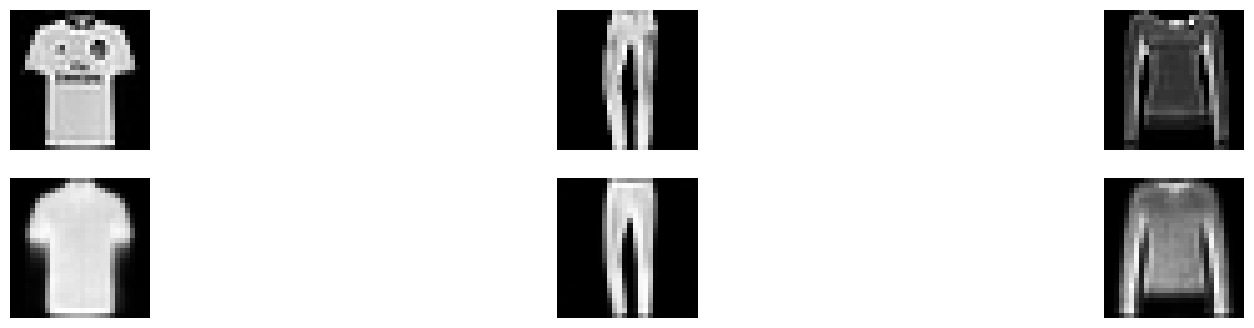

In [12]:
#visualize some reconstructed images
num_images = 3
test_images = x_val[:num_images]
reconstructed_images = vae.decode(vae.reparameterize(*vae.encode(test_images))[1])
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
for i in range(num_images):
    axes[0, i].imshow(test_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
plt.show()

C:\Users\Maanav\AppData\Local\Temp\ipykernel_13168\924685435.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels(fashion_labels)


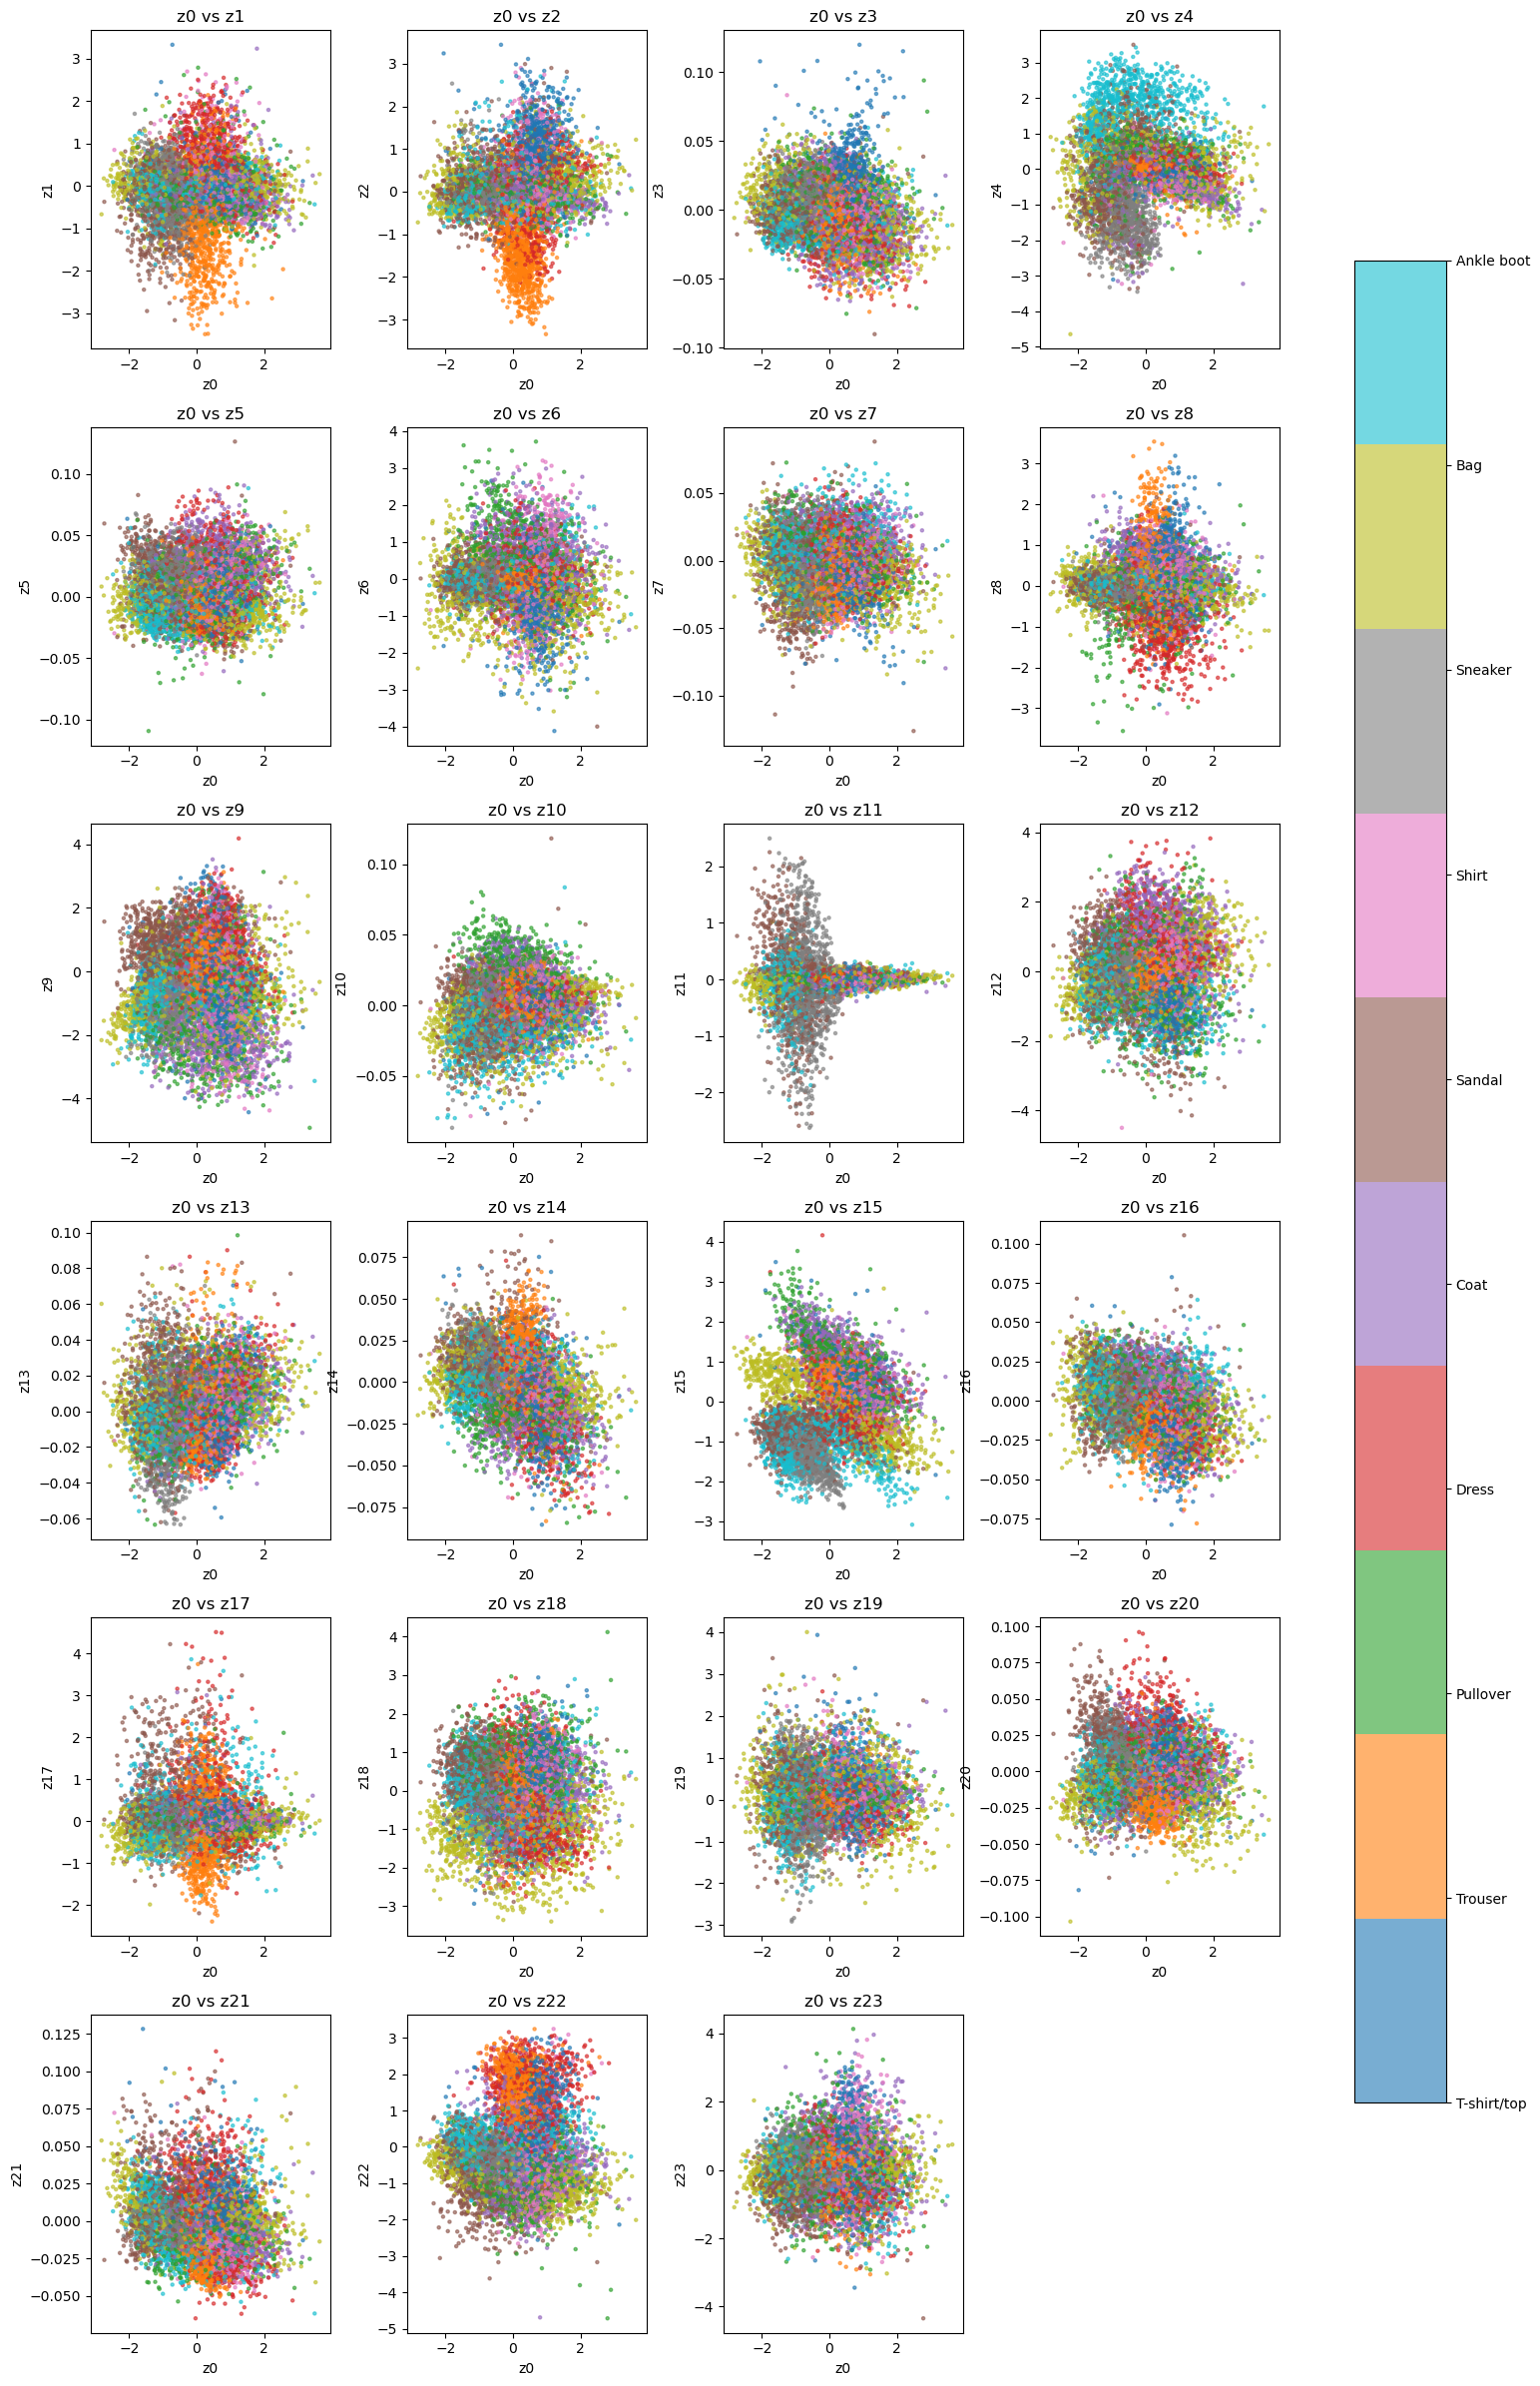

In [17]:
#visualize each latent dimension against the first one
z_mu, z_log_var = vae.encode(x_val)
fashion_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
# use mean to keep the plot deterministic
z = z_mu
num_plots = LATENT_SHAPE - 1
cols = 4
rows = int(np.ceil(num_plots / cols))
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), squeeze=False)
mappable = None
for i in range(num_plots):
    ax = axes[i // cols][i % cols]
    ax.scatter(z[:, 0], z[:, i + 1], c=y_val, cmap='tab10', s=5, alpha=0.6)
    ax.set_xlabel('z0')
    ax.set_ylabel(f'z{i + 1}')
    ax.set_title(f'z0 vs z{i + 1}')
for j in range(num_plots, rows * cols):
    axes[j // cols][j % cols].axis('off')
plt.tight_layout()

cbar = fig.colorbar(axes[0, 0].collections[0], ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_ticklabels(fashion_labels)
plt.show()


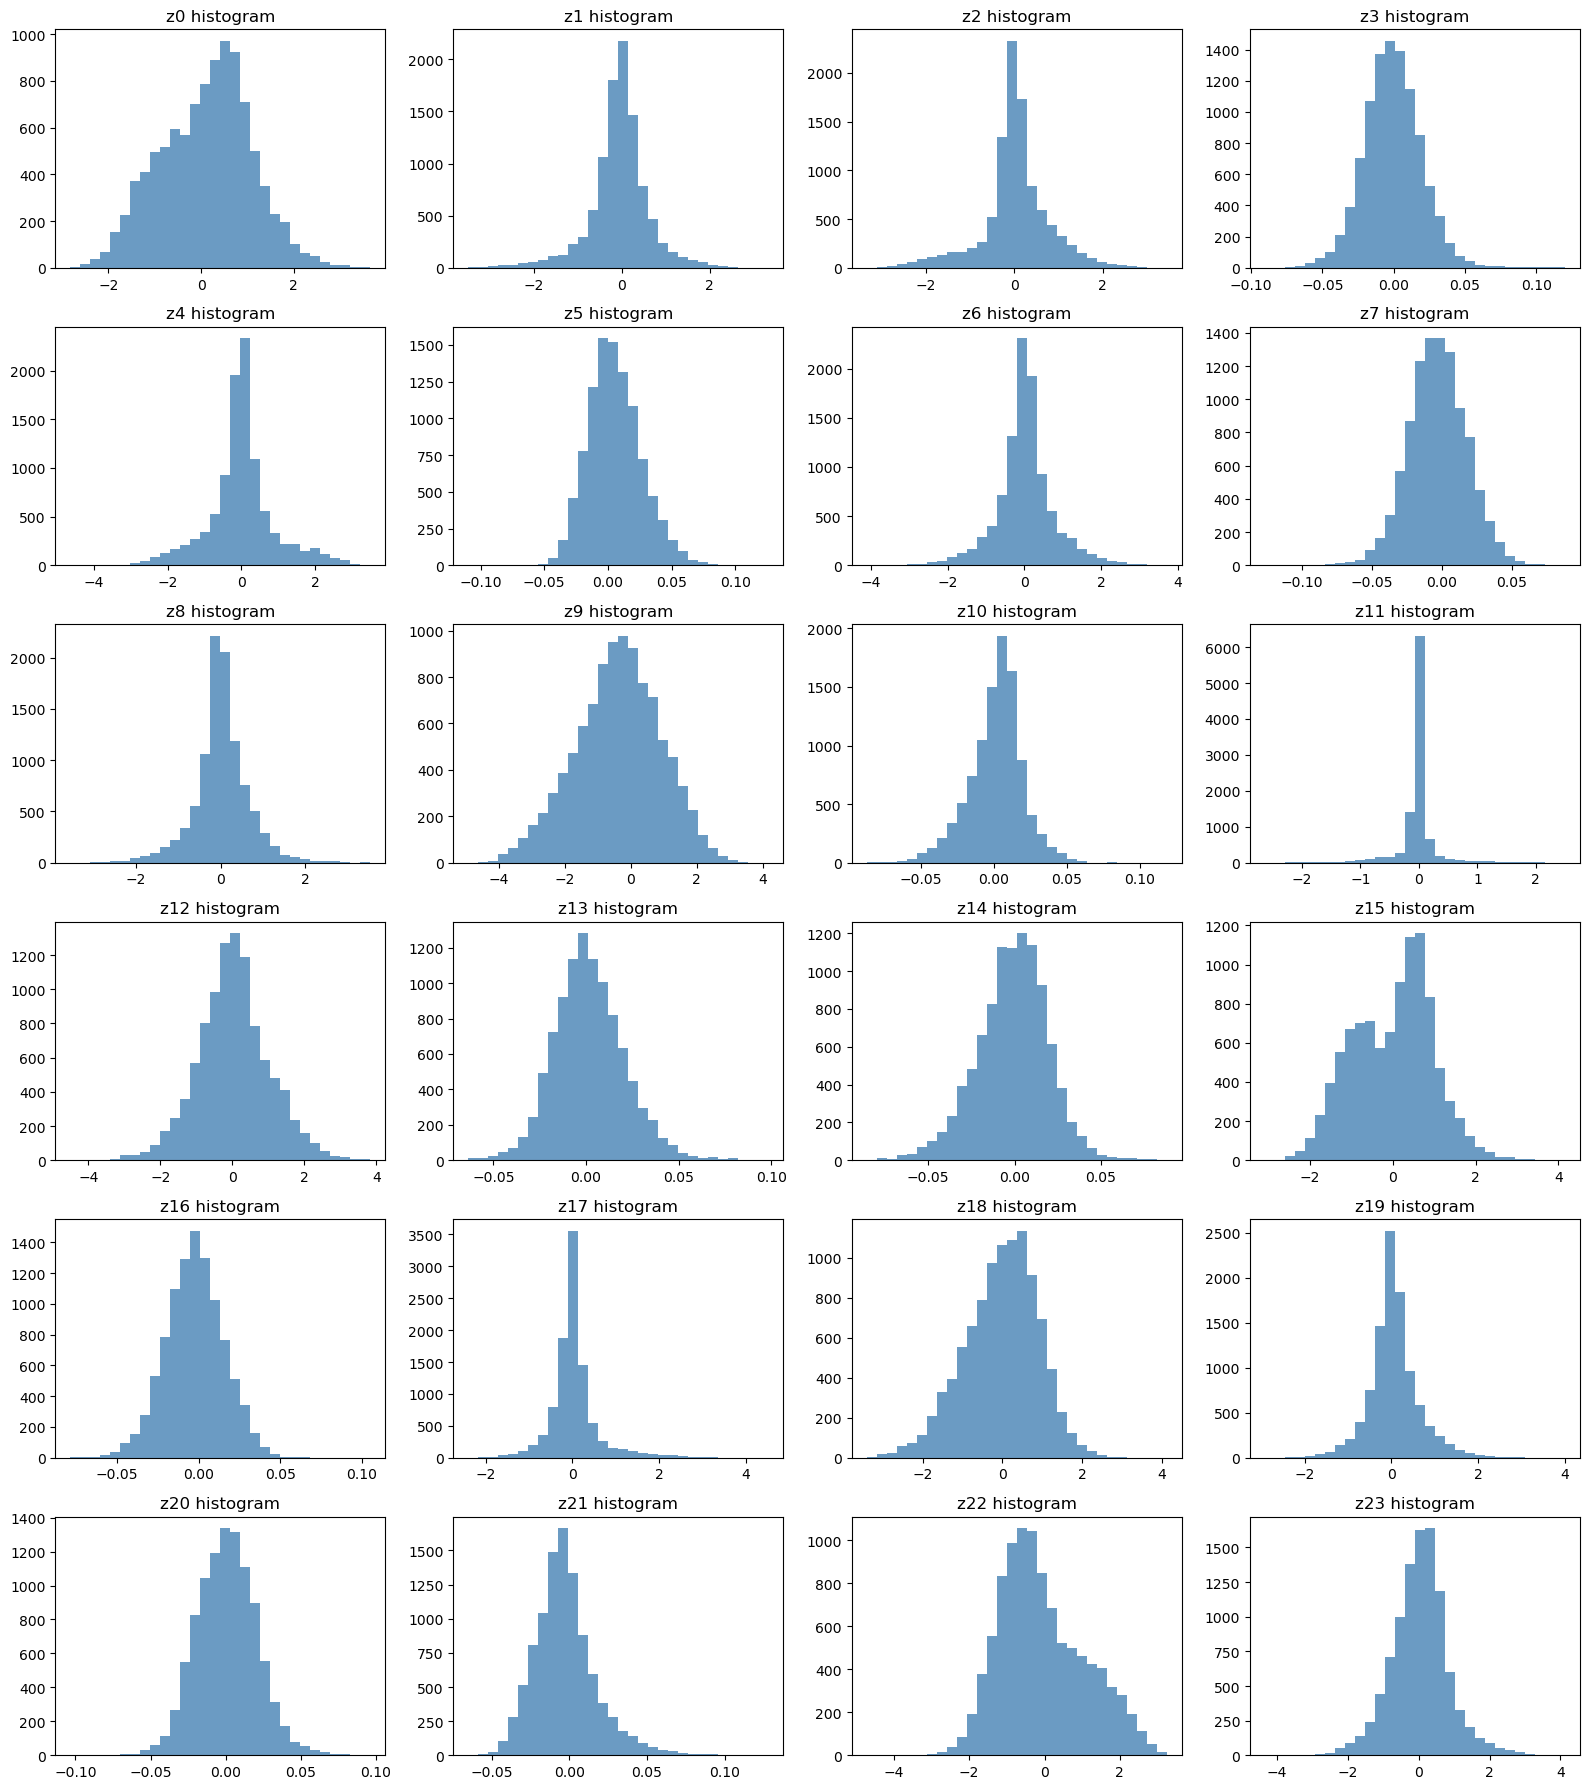

In [18]:
num_plots = LATENT_SHAPE
cols = 4
rows = int(np.ceil(num_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows), squeeze=False)
for i in range(num_plots):
    ax = axes[i // cols][i % cols]
    ax.hist(z[:, i], bins=30, color='steelblue', alpha=0.8)
    ax.set_title(f'z{i} histogram')

for j in range(num_plots, rows * cols):
    axes[j // cols][j % cols].axis('off')

plt.tight_layout()
plt.show()

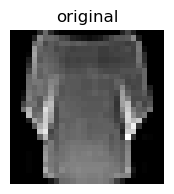

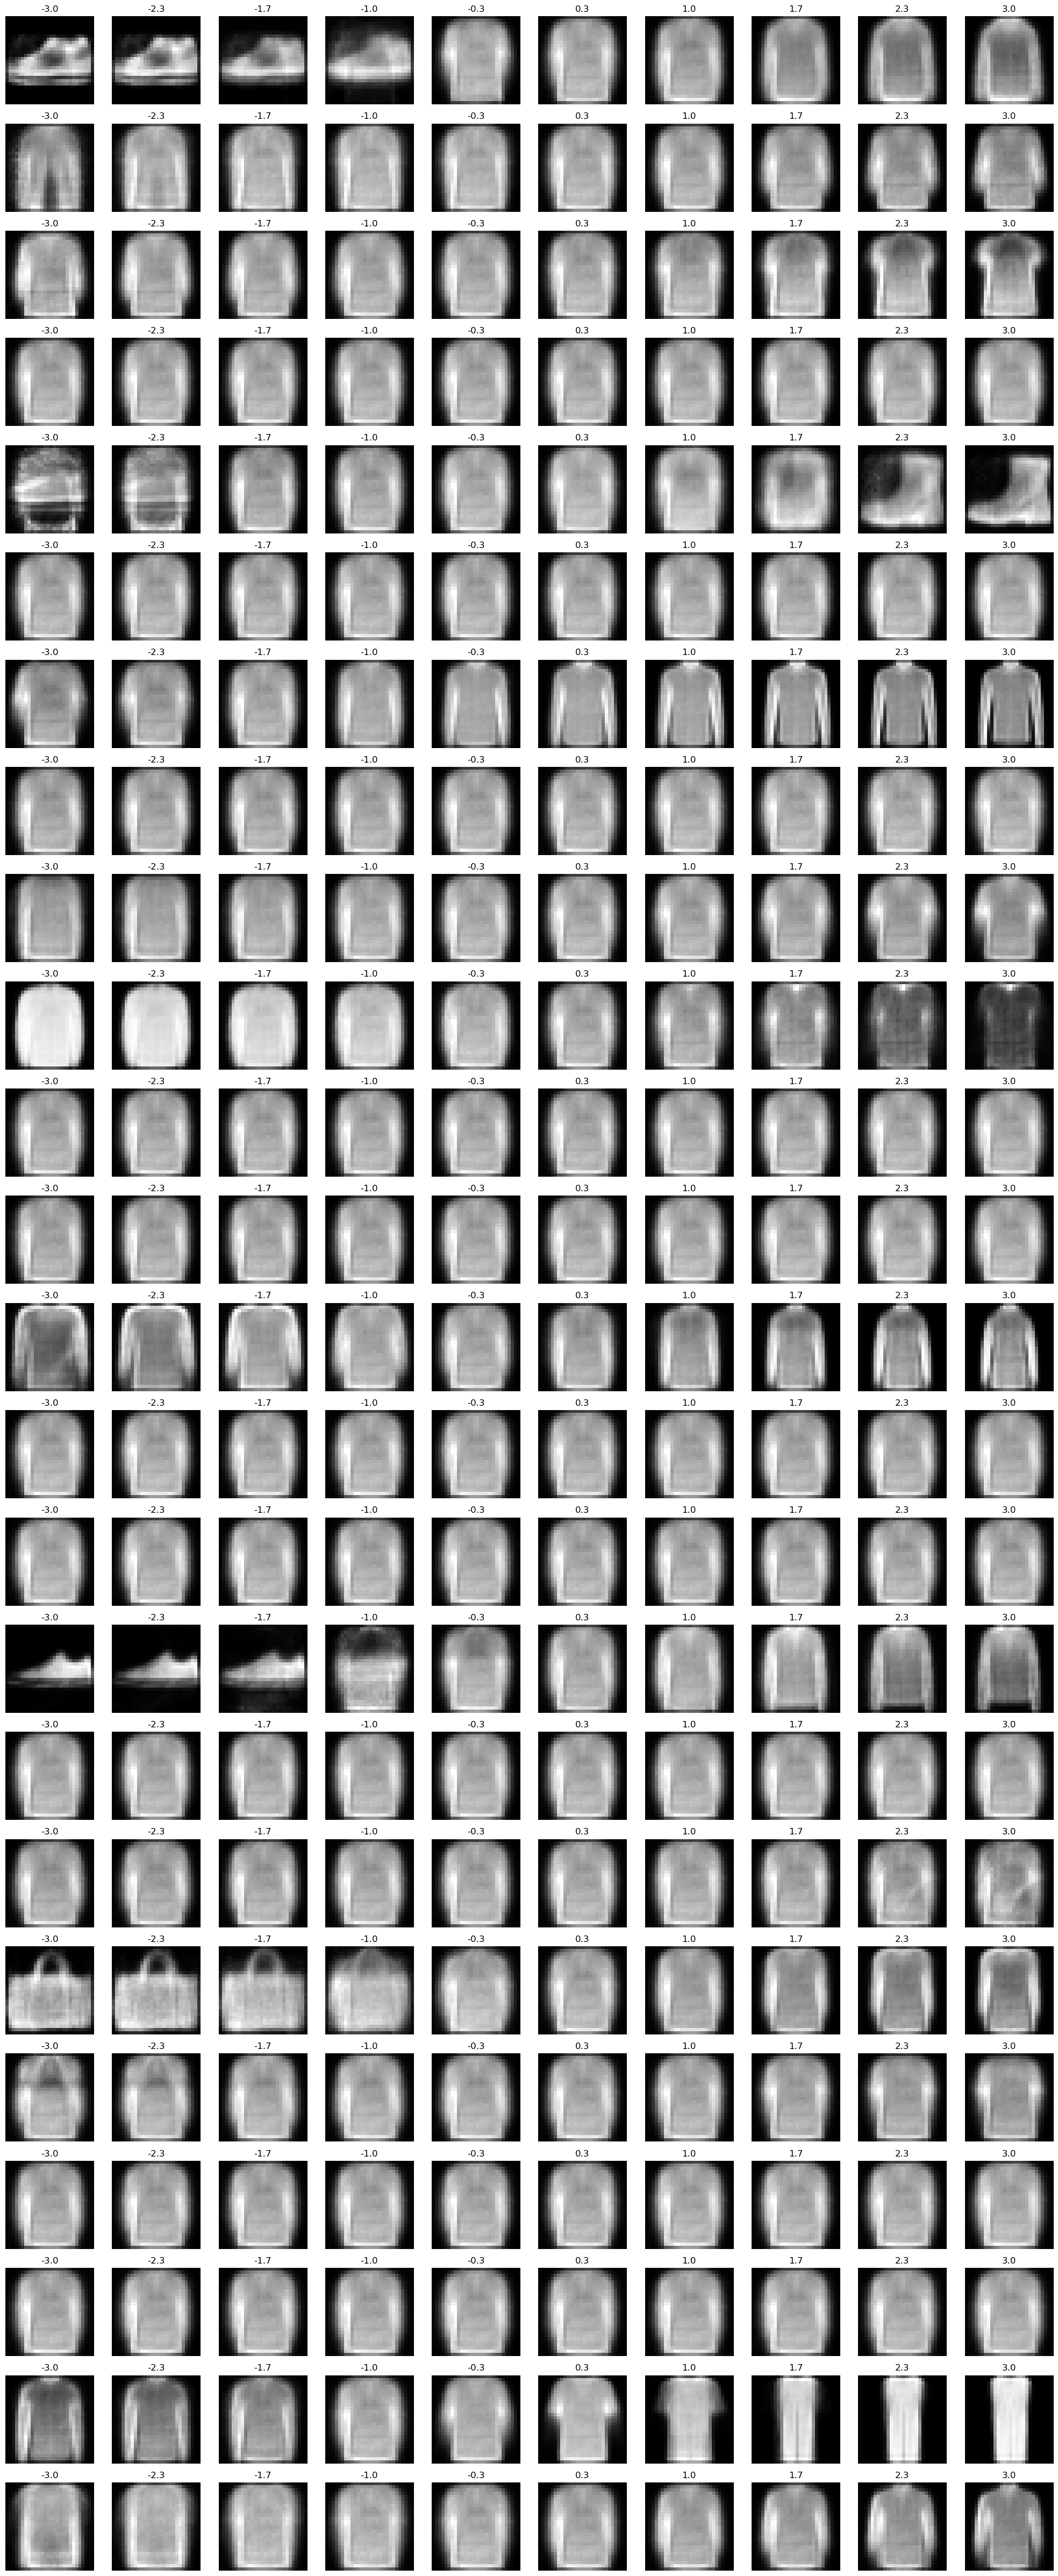

In [34]:
# pick one image
idx = 5
x = x_val[idx:idx+1]

z_mu, z_log_var = vae.encode(x)
z0 = z_mu.copy()

values = np.linspace(-3, 3, 10)

plt.figure(figsize=(2, 2))
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.title('original')
plt.axis('off')
plt.show()

rows = LATENT_SHAPE
cols = len(values)
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows), squeeze=False)

for dim in range(LATENT_SHAPE):
    for i, v in enumerate(values):
        z = z0.copy()
        z[0, dim] = v
        x_gen = vae.decode(z)
        ax = axes[dim][i]
        ax.imshow(x_gen.reshape(28, 28), cmap='gray')
        if i == 0:
            ax.set_ylabel(f'z{dim}', rotation=0, labelpad=20, va='center')
        ax.set_title(f'{v:.1f}')
        ax.axis('off')

plt.tight_layout()
plt.show()